In [14]:
%matplotlib notebook
import numpy as np
import pandas as pd
import geopandas as gpd
from itertools import combinations as comb
from geopandas.tools import overlay
import os
from sandpyper.common import coords_to_points


from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import rasterio as ras
from rasterio.plot import show

from sandpyper.sandpyper import ProfileSet
from sandpyper.common import get_sil_location, get_opt_k
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from tqdm.notebook import tqdm_notebook as tqdm

pd.options.mode.chained_assignment = None  # default='warn'

crs_dict_string= {
                 'mar': {'init': 'epsg:32754'},
                 'leo':{'init': 'epsg:32755'}
                 }


def kmeans_sa(merged_df, ks, feature_set, thresh_k=5, random_state=10):
    """
    Function to use KMeans on all surveys with the optimal k obtained from the Silhouette Analysis.
    It uses KMeans as a clusterer.

    Args:
        merged_df (Pandas dataframe): The clean and merged dataframe containing the features. Must contain the columns point_id, location and survey_date, as well as the
        ks (int, dict): number of clusters (k) or dictionary containing the optimal k for each survey. See get_opt_k function.
        feature_set (list): List of names of features in the dataframe to use for clustering.
        thresh_k (int): Minimim k to be used. If survey-specific optimal k is below this value, then k equals the average k of all above threshold values.
        random_state (int): Random seed used to make the randomisation deterministic.

    Returns:
        data_classified (pd.DataFrame): A dataframe containing the label_k column, with point_id, location, survey_date and the features used to cluster the data.
    """


    merged_df.dropna(inplace=True)
    list_locs = merged_df.location.unique()

    scaler = MinMaxScaler()
    data_classified = pd.DataFrame()

    # Set a threshold k, in case a k is lower than 5, use the mean optimal k
    # of the other surveys above threshold

    # # Compute the mean optimal k of above threshold ks
    if isinstance(ks, dict):
        arr_k = np.array([i for i in ks.values() if i > thresh_k])
        mean_threshold_k = np.int(np.round(np.mean(arr_k), 0))
    else:
        pass

    for location in tqdm(list_locs):

        list_dates = merged_df.query(f"location=='{location}'").raw_date.unique()

        for survey_date_in in tqdm(list_dates):

            data_in = merged_df.query(
                f"location=='{location}'& raw_date == {survey_date_in}"
            )
            data_clean = data_in[feature_set].apply(pd.to_numeric)

            if isinstance(ks, dict):
                k = ks[f"{location}_{survey_date_in}"]
            else:
                k=ks

            if k < thresh_k:
                k = mean_threshold_k
            else:
                pass

            minmax_scaled_df = scaler.fit_transform(np.nan_to_num(data_clean))

            clusterer = KMeans(
                n_clusters=k,
                init="k-means++",
                algorithm="elkan",
                tol=0.0001,
                random_state=random_state,
            )

            data_in["label_k"] = clusterer.fit_predict(minmax_scaled_df)

            data_classified = pd.concat(
                [data_in, data_classified], ignore_index=True
            )

    return data_classified


def check_dicts_duplicated_values(l_dicts):

    dict_check = {}
    dict_dups = {}
    all_dicts=[dicto for dicto in l_dicts.values()]

    for dict_in in all_dicts:
        for key in set().union(*all_dicts):
            if key in dict_in:
                dict_check.setdefault(key, []).extend(dict_in[key])

    for survey, labels in dict_check.items():
        duplicated=[x for x in labels if labels.count(x) > 1]
        if len(duplicated)>=1:
            dict_dups.update({survey:set(set(duplicated))})

    if len(dict_dups)>0:
        raise ValueError(f"Duplicated label_k found in the following dictionaries.\n\n{dict_dups}\n\nPlease revise and assigned those labels_k to only one class dictionary.")



def classify_labelk(labelled_dataset,l_dicts, cluster_field='label_k', fill_class='sand'):

    check_dicts_duplicated_values(l_dicts)

    labelled_dataset["pt_class"]=np.nan

    all_keys = set().union(*(d.keys() for d in [i for i in l_dicts.values()]))
    class_names=l_dicts.keys()

    classed_df=pd.DataFrame()

    for loc in labelled_dataset.location.unique():
        data_in_loc=labelled_dataset.query(f"location=='{loc}'")[["location","raw_date",cluster_field,"pt_class",'point_id']]

        for raw_date in data_in_loc.raw_date.unique():
            loc_date_tag=f"{loc}_{raw_date}"
            data_in=data_in_loc.query(f"raw_date=={raw_date}")

            if loc_date_tag in all_keys:

                for class_in in class_names:

                    if loc_date_tag in l_dicts[class_in].keys():
                        loc_date_class_values=l_dicts[class_in][loc_date_tag]

                        if len(loc_date_class_values)>=1:
                            tmp_dict={label_k:class_in for label_k in loc_date_class_values}
                            data_in['pt_class'].update(data_in[cluster_field].map(tmp_dict))

                        else:
                            pass
                    else:
                        pass
            else:
                print(f"{loc_date_tag} not in the class dictionaries. All their labels assigned to fill_class {fill_class}.")
                data_in["pt_class"].fillna(fill_class, inplace=True)

            classed_df=pd.concat([classed_df,data_in], ignore_index=True)

    merged=labelled_dataset.iloc[:,:-1].merge(right=classed_df[['point_id','pt_class']], on='point_id', how='left')

    merged["pt_class"].fillna(fill_class, inplace=True)
    return merged


def cleanit(to_clean, l_dicts, cluster_field='label_k', fill_class='sand',
            watermasks_path=None, water_label='water',
            shoremasks_path=None, label_corrections_path=None,
            default_crs={'init': 'epsg:32754'}, crs_dict_string=None,
           geometry_field='coordinates'):

    print("Reclassifying dataset with the provided dictionaries." )
    to_clean_classified=classify_labelk(to_clean, l_dicts)

    if watermasks_path==None and shoremasks_path==None and label_corrections_path==None:
        print("No cleaning polygones have been passed. Returning classified dataset.")
        return to_clean_classified

    processes=[]

    #______ LABELS FINETUNING_______________

    if label_corrections_path != None:
        if os.path.isfile(label_corrections_path):
            label_corrections=gpd.read_file(label_corrections_path)
            print(f"Label corrections provided in CRS: {label_corrections.crs}")
            processes.append("polygon finetuning")
            to_update_finetune=pd.DataFrame()


            for loc in label_corrections.location.unique():
                print(f"Fine tuning in {loc}.")

                to_clean_subset_loc=to_clean_classified.query(f" location == '{loc}'")

                for raw_date in tqdm(label_corrections.query(f"location=='{loc}'").raw_date.unique()):

                    subset_finetune_polys=label_corrections.query(f"location=='{loc}' and raw_date== {raw_date}")

                    for i,row in subset_finetune_polys.iterrows(): # loops through all the polygones

                        target_k=int(row['target_label_k'])
                        new_class=row['new_class']

                        if target_k != 999:
                            data_in=to_clean_subset_loc.query(f"raw_date == {raw_date} and label_k== {target_k}")

                        elif target_k == 999:
                            data_in=to_clean_subset_loc.query(f"raw_date == {raw_date}")

                        selection=data_in[data_in.coordinates.intersects(row.geometry)]

                        if selection.shape[0]==0:
                            selection=data_in[data_in.to_crs(crs_dict_string[loc]).coordinates.intersects(row.geometry)]
                        else:
                            pass
                        selection["finetuned_label"]=new_class

                        print(f"Fine-tuning label_k {target_k} to {new_class} in {loc}-{raw_date}, found {selection.shape[0]} pts.")
                        to_update_finetune=pd.concat([selection,to_update_finetune], ignore_index=True)

            classed_df_finetuned=to_clean_classified.merge(right=to_update_finetune.loc[:,['point_id','finetuned_label']], # Left Join
                                         how='left', validate='one_to_one')

            classed_df_finetuned.finetuned_label.fillna(classed_df_finetuned.pt_class, inplace=True) # Fill NaN with previous sand labels
        else:
            raise NameError("Label correction file path is invalid.")


    else:
        pass

    if shoremasks_path == None and watermasks_path == None:
        print(f"{processes} completed.")

        if 'watermasked_label' in classed_df_finetuned.columns and 'finetuned_label' not in classed_df_finetuned.columns:
            classed_df_finetuned['pt_class']=classed_df_finetuned.watermasked_label
            classed_df_finetuned.drop(['watermasked_label'], axis=1, inplace=True)

        elif 'finetuned_label' in classed_df_finetuned.columns and 'watermasked_label' not in classed_df_finetuned.columns:
            classed_df_finetuned['pt_class']=classed_df_finetuned.finetuned_label
            classed_df_finetuned.drop(['finetuned_label'], axis=1, inplace=True)

        elif 'finetuned_label' in classed_df_finetuned.columns and 'watermasked_label' in classed_df_finetuned.columns:
            classed_df_finetuned['pt_class']=classed_df_finetuned.watermasked_label
            classed_df_finetuned.drop(['finetuned_label','watermasked_label'], axis=1, inplace=True)

        else:
            pass

        return classed_df_finetuned
    else:
        pass

    #______ WATERMASKING_______________

    if watermasks_path != None:
        if os.path.isfile(watermasks_path):
            # apply watermasks
            watermask=gpd.read_file(watermasks_path)
            print(f"watermask  provided in CRS: {watermask.crs}")


            print("Applying watermasks cleaning.")
            processes.append("watermasking")

            if "polygon finetuning" in processes:
                dataset_to_clean=classed_df_finetuned
                starting_labels='finetuned_label'
            else:
                dataset_to_clean=to_clean_classified
                starting_labels='pt_class'


            to_update_watermasked=pd.DataFrame()

            for loc in watermask.location.unique():
                print(f"Watermasking in {loc}.")

                for raw_date in tqdm(watermask.query(f"location=='{loc}'").raw_date.unique()):

                    subset_data=dataset_to_clean.query(f"location=='{loc}' and raw_date == {raw_date}")
                    subset_masks=watermask.query(f"location=='{loc}' and raw_date == {raw_date}")

                    selection=subset_data[subset_data.geometry.intersects(subset_masks.geometry)]
                    if selection.shape[0]==0:
                        selection=subset_data[subset_data.geometry.intersects(subset_masks.to_crs(crs_dict_string[loc]).geometry.any())]
                    else:
                        pass

                    print(f"Setting to {water_label} {selection.shape[0]} pts overlapping provided watermasks.")

                    selection["watermasked_label"]=water_label

                    to_update_watermasked=pd.concat([selection,to_update_watermasked], ignore_index=True)

            classed_df_watermasked=dataset_to_clean.merge(right=to_update_watermasked.loc[:,['point_id','watermasked_label']], # Left Join
                                         how='left', validate='one_to_one')
            classed_df_watermasked.watermasked_label.fillna(classed_df_watermasked.loc[:,starting_labels], inplace=True) # Fill NaN with previous sand labels

            if shoremasks_path == None:
                print(f"{processes} completed.")

                if 'watermasked_label' in classed_df_watermasked.columns and 'finetuned_label' not in classed_df_watermasked.columns:
                    classed_df_watermasked['pt_class']=classed_df_watermasked.watermasked_label
                    classed_df_watermasked.drop(['watermasked_label'], axis=1, inplace=True)

                elif 'finetuned_label' in classed_df_watermasked.columns and 'watermasked_label' not in classed_df_watermasked.columns:
                    classed_df_watermasked['pt_class']=classed_df_watermasked.finetuned_label
                    classed_df_watermasked.drop(['finetuned_label'], axis=1, inplace=True)

                elif 'finetuned_label' in classed_df_watermasked.columns and 'watermasked_label' in classed_df_watermasked.columns:
                    classed_df_watermasked['pt_class']=classed_df_watermasked.watermasked_label
                    classed_df_watermasked.drop(['finetuned_label','watermasked_label'], axis=1, inplace=True)

                else:
                    pass

                return classed_df_watermasked
        else:
            raise NameError("watermask file path is invalid.")

    else:
        pass

    #______ SHOREMASKING_______________

    if shoremasks_path != None:
        if os.path.isfile(shoremasks_path):
            # apply shoremasks
            shoremask=gpd.read_file(shoremasks_path)
            print(f"shoremask  provided in CRS: {shoremask.crs}")
            print("Applying shoremasks cleaning.")
            processes.append("shoremasking")


            if "polygon finetuning" in processes and "watermasking" not in processes:
                dataset_to_clean=classed_df_finetuned
            elif "polygon finetuning" not in processes and "watermasking" in processes:
                dataset_to_clean=classed_df_watermasked
            elif "polygon finetuning"  in processes and "watermasking" in processes:
                dataset_to_clean=classed_df_watermasked
            else:
                dataset_to_clean=to_clean_classified

            inshore_cleaned=gpd.GeoDataFrame()
            for loc in shoremask.location.unique():
                print(f"Shoremasking in {loc}.")

                shore=shoremask.query(f"location=='{loc}'")
                loc_selection=dataset_to_clean.query(f"location=='{loc}'")
                in_shore=loc_selection[loc_selection.geometry.intersects(shore.geometry)]
                if in_shore.shape[0]>=1:
                    pass
                else:
                    in_shore=loc_selection[loc_selection.geometry.intersects(shore.to_crs(crs_dict_string[loc]).geometry.any())]

                print(f"Removing {loc_selection.shape[0] - in_shore.shape[0]} pts falling outside provided shore polygones.")
                inshore_cleaned=pd.concat([in_shore,inshore_cleaned], ignore_index=True)

            print(f"{processes} completed.")

            if 'watermasked_label' in inshore_cleaned.columns and 'finetuned_label' not in inshore_cleaned.columns:
                inshore_cleaned['pt_class']=inshore_cleaned.watermasked_label
                inshore_cleaned.drop(['watermasked_label'], axis=1, inplace=True)

            elif 'finetuned_label' in inshore_cleaned.columns and 'watermasked_label' not in inshore_cleaned.columns:
                inshore_cleaned['pt_class']=inshore_cleaned.finetuned_label
                inshore_cleaned.drop(['finetuned_label'], axis=1, inplace=True)

            elif 'finetuned_label' in inshore_cleaned.columns and 'watermasked_label' in inshore_cleaned.columns:
                inshore_cleaned['pt_class']=inshore_cleaned.watermasked_label
                inshore_cleaned.drop(['finetuned_label','watermasked_label'], axis=1, inplace=True)

            else:
                pass

            return inshore_cleaned
        else:
            raise NameError("shoremask file path is invalid.")

In [2]:
water_dict={'leo_20180606':[0,9,10],
'leo_20180713':[0,3,4,7],
'leo_20180920':[0,2,6,7],
'leo_20190211':[0,2,5],
'leo_20190328':[2,4,5],
'leo_20190731':[0,2,8,6],
'mar_20180601':[1,6],
'mar_20180621':[4,6],
'mar_20180727':[0,5,9,10],
'mar_20180925':[6],
'mar_20181113':[1],
'mar_20181211':[4],
'mar_20190205':[],
'mar_20190313':[],
'mar_20190516':[4,7]}

no_sand_dict={'leo_20180606':[5],
'leo_20180713':[],
'leo_20180920':[],
'leo_20190211':[1],
'leo_20190328':[],
'leo_20190731':[1],
'mar_20180601':[4,5],
'mar_20180621':[3,5],
'mar_20180727':[4,7],
'mar_20180925':[5],
'mar_20181113':[0],
'mar_20181211':[0],
'mar_20190205':[0,5],
'mar_20190313':[4],
'mar_20190516':[2,5]}

veg_dict={'leo_20180606':[1,3,7,8],
'leo_20180713':[1,5,9],
'leo_20180920':[1,4,5],
'leo_20190211':[4],
'leo_20190328':[0,1,6],
'leo_20190731':[3,7],
'mar_20180601':[0,7],
'mar_20180621':[1,7],
'mar_20180727':[1,3],
'mar_20180925':[1,3],
'mar_20181113':[3],
'mar_20181211':[2],
'mar_20190205':[3],
'mar_20190313':[1,5],
'mar_20190516':[0]}

sand_dict={'leo_20180606':[2,4,6],
'leo_20180713':[2,6,8],
'leo_20180920':[3],
'leo_20190211':[3],
'leo_20190328':[3],
'leo_20190731':[4,5],
'mar_20180601':[2,3],
'mar_20180621':[0,2],
'mar_20180727':[2,6,8],
'mar_20180925':[0,4,2],
'mar_20181113':[2,4],
'mar_20181211':[3,1],
'mar_20190205':[1,2,4],
'mar_20190313':[0,2,3],
'mar_20190516':[1,3,6]}

l_dicts={'no_sand': no_sand_dict,
         'sand': sand_dict,
        'water': water_dict,
        'veg':veg_dict}# set the path to the test data folder
test_data_folder = r"C:\my_packages\sandpyper\examples\test_data"

# the paths to the DSM, orthophotos and transect directories
dirNameDSM=Path(test_data_folder + r"\dsm_1m")
dirNameOrtho=Path(test_data_folder + r"\orthos_1m")
dirNameTrans=Path(test_data_folder + r"\transects")

# path to the LoD transects

lod_mode=Path(test_data_folder + r"\lod_transects")


# the location codes used for the monitored locations
loc_codes=["mar","leo"]


# the keyword search dictionary
loc_search_dict = {   'leo': ['St','Leonards','leonards','leo'],
                   'mar': ['Marengo','marengo','mar'] }


# the EPSG codes of the coordinate reference systems for each location code (location) given in CRS string format
crs_dict_string= {
                 'mar': {'init': 'epsg:32754'},
                 'leo':{'init': 'epsg:32755'}
                 }

# the transect spacing of the transects
transects_spacing=20

In [3]:
# set the path to the test data folder
test_data_folder = r"C:\my_packages\sandpyper\examples\test_data"

# the paths to the DSM, orthophotos and transect directories
dirNameDSM=Path(test_data_folder + r"\dsm_1m")
dirNameOrtho=Path(test_data_folder + r"\orthos_1m")
dirNameTrans=Path(test_data_folder + r"\transects")

# path to the LoD transects

lod_mode=Path(test_data_folder + r"\lod_transects")


# the location codes used for the monitored locations
loc_codes=["mar","leo"]


# the keyword search dictionary
loc_search_dict = {   'leo': ['St','Leonards','leonards','leo'],
                   'mar': ['Marengo','marengo','mar'] }


# the transect spacing of the transects
transects_spacing=20

P=ProfileSet(dirNameDSM=dirNameDSM,
            dirNameOrtho=dirNameOrtho,
            dirNameTrans=dirNameTrans,
            transects_spacing=transects_spacing,
            loc_codes=loc_codes,
            loc_search_dict=loc_search_dict,
            crs_dict_string=crs_dict_string,
            check="all")

# run extraction from DSMs and orthos with 1m sampling steps and add X and Y fields to output geodataframe.
# use LoDs profiles provided.

P.extract_profiles(mode='all',tr_ids='tr_id',sampling_step=1,add_xy=True,lod_mode=lod_mode)

# Run interatively KMeans + SA using the feature_set provided
#feel free to add 

feature_set=["band1","band2","band3","distance"]
sil_df=get_sil_location(P.profiles,
                        ks=(2,15), 
                        feature_set=feature_set,
                       random_state=10)

opt_k=get_opt_k(sil_df, sigma=0 )
opt_k

In [4]:
opt_k_broke={'leo_20180606': 10,
 'leo_20180713': 10,
 'leo_20180920': 10,
 'leo_20190211': 10,
 'leo_20190328': 10,
 'leo_20190731': 10,
 'mar_20180601': 10,
 'mar_20180621': 10,
 'mar_20180727': 10,
 'mar_20180925': 10,
 'mar_20181113': 10,
 'mar_20181211': 10,
 'mar_20190205': 10,
 'mar_20190313': 10,
 'mar_20190516': 10}

In [5]:
profiles=pd.read_csv(r"C:\my_packages\tmp\check_cleanit.csv")
profiles

,Unnamed: 0,distance,z,coordinates,location,survey_date,raw_date,tr_id,point_id,x,y,band1,band2,band3
0,0,0.0,0.007440,POINT (731646.903760184 5705523.468988597),mar,2019-05-16,20190516,24,64121091m2580400ar00,731646.903760,5.705523e+06,114.0,139.0,128.0
1,1,1.0,0.008439,POINT (731646.0783010386 5705524.033450465),mar,2019-05-16,20190516,24,64123091m2580600ar10,731646.078301,5.705524e+06,117.0,139.0,127.0
2,2,2.0,0.010800,POINT (731645.2528418931 5705524.597912331),mar,2019-05-16,20190516,24,64129091m2530100ar20,731645.252842,5.705525e+06,122.0,140.0,127.0
3,3,3.0,0.011350,POINT (731644.4273827478 5705525.162374198),mar,2019-05-16,20190516,24,64124091m2570800ar30,731644.427383,5.705525e+06,125.0,144.0,133.0
4,4,4.0,0.028030,POINT (731643.6019236024 5705525.726836066),mar,2019-05-16,20190516,24,64120091m2520400ar40,731643.601924,5.705526e+06,126.0,145.0,133.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32800,32800,44.0,NaN,POINT (300201.5018478121 5772859.890627191),leo,2018-06-06,20180606,0,60101080l2624100eo40,300201.501848,5.772860e+06,NaN,NaN,NaN
32801,32801,45.0,NaN,POINT (300202.2980100062 5772860.495710459),leo,2018-06-06,20180606,0,60100080l2665200eo40,300202.298010,5.772860e+06,NaN,NaN,NaN
32802,32802,46.0,NaN,POINT (300203.0941722003 5772861.100793727),leo,2018-06-06,20180606,0,60100080l2606300eo40,300203.094172,5.772861e+06,NaN,NaN,NaN
32803,32803,47.0,NaN,POINT (300203.8903343944 5772861.705876994),leo,2018-06-06,20180606,0,60109080l2647400eo40,300203.890334,5.772862e+06,NaN,NaN,NaN


In [6]:
feature_set=["band1","band2","band3","distance"]

#prof_works=kmeans_sa(profiles, ks=opt_k,feature_set=feature_set )
prof_broke=kmeans_sa(profiles, ks=opt_k_broke,feature_set=feature_set )

C:\new_temp/ipykernel_34876/3742184756.py:58: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mean_threshold_k = np.int(np.round(np.mean(arr_k), 0))


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [7]:
from sandpyper.common import coords_to_points

prof_broke['coordinates']=prof_broke.coordinates.apply(coords_to_points)

In [8]:
cluster_field='label_k'
fill_class='ciao'
watermasks_path=None
water_label='ciao'
shoremasks_path=None
label_corrections_path=None
default_crs={'init': 'epsg:32754'}
crs_dict_string=None
geometry_field='coordinates'

In [7]:
# the EPSG codes of the coordinate reference systems for each location code (location) given in CRS string format
crs_dict_string= {
                 'mar': {'init': 'epsg:32754'},
                 'leo':{'init': 'epsg:32755'}
                 }


prof_broke=gpd.GeoDataFrame(prof_broke, crs=crs_dict_string['mar'], geometry='coordinates')

TypeError: Input must be valid geometry objects: POINT (299873.2179654416 5773731.859571524)

In [10]:

label_corrections_path=Path(test_data_folder + r"\clean\label_corrections.gpkg")
watermasks_path=Path(test_data_folder + r"\clean\watermasks.gpkg")
shoremasks_path=Path(test_data_folder + r"\clean\shoremasks.gpkg")

In [14]:
print("Reclassifying dataset with the provided dictionaries." )
to_clean_classified=classify_labelk(to_clean, l_dicts)

Reclassifying dataset with the provided dictionaries.


In [146]:

if watermasks_path==None and shoremasks_path==None and label_corrections_path==None:
    print("No cleaning polygones have been passed. Returning classified dataset.")

processes=[]

#______ LABELS FINETUNING_______________

if label_corrections_path != None:
    if os.path.isfile(label_corrections_path):
        label_corrections=gpd.read_file(label_corrections_path)
        print(f"Label corrections provided in CRS: {label_corrections.crs}")
        processes.append("polygon finetuning")
        to_update_finetune=pd.DataFrame()


        for loc in label_corrections.location.unique():
            print(f"Fine tuning in {loc}.")

            to_clean_subset_loc=to_clean_classified.query(f" location == '{loc}'")

            for raw_date in tqdm(label_corrections.query(f"location=='{loc}'").raw_date.unique()):

                subset_finetune_polys=label_corrections.query(f"location=='{loc}' and raw_date== {raw_date}")
                print(loc)
                print(raw_date)

                for i,row in subset_finetune_polys.iterrows(): # loops through all the polygones

                    target_k=int(row['target_label_k'])
                    new_class=row['new_class']
                    print(target_k)
                    print(new_class)

                    if target_k != 999:
                        data_in=to_clean_subset_loc.query(f"raw_date == {raw_date} and label_k== {target_k}")

                    elif target_k == 999:
                        data_in=to_clean_subset_loc.query(f"raw_date == {raw_date}")

                    selection=data_in[data_in.coordinates.intersects(row.geometry)]

                    if selection.shape[0]==0:
                        selection=data_in[data_in.to_crs(crs_dict_string[loc]).coordinates.intersects(row.geometry)]
                        
                        if selection.shape[0]==0:
                            print(f"The label correction file provids polygons to transform label_k {target_k} into {new_class} in {loc} in date {raw_date}, but these polygons do not overlap any points with such target k! Double check your files if this is unwanted.")
                        else:
                            pass
                    else:
                        pass
                    selection["finetuned_label"]=new_class

                    print(f"Fine-tuning label_k {target_k} to {new_class} in {loc}-{raw_date}, found {selection.shape[0]} pts.")
                    to_update_finetune=pd.concat([selection,to_update_finetune], ignore_index=True)

        classed_df_finetuned=to_clean_classified.merge(right=to_update_finetune.loc[:,['point_id','finetuned_label']], # Left Join
                                     how='left', validate='one_to_one')

        classed_df_finetuned.finetuned_label.fillna(classed_df_finetuned.pt_class, inplace=True) # Fill NaN with previous sand labels
    else:
        raise NameError("Label correction file path is invalid.")


else:
    pass

Label corrections provided in CRS: epsg:32754
Fine tuning in leo.


C:\anaconda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


  0%|          | 0/6 [00:00<?, ?it/s]

C:\anaconda3\envs\sandpyper_env\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


leo
20180606
3
no_sand
The label correction file provids polygons to transform label_k 3 into no_sand in leo in date 20180606, but these polygons do not overlap any points with such target k! Double check your files if this is unwanted.
Fine-tuning label_k 3 to no_sand in leo-20180606, found 0 pts.
8
no_sand


C:\anaconda3\envs\sandpyper_env\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


The label correction file provids polygons to transform label_k 8 into no_sand in leo in date 20180606, but these polygons do not overlap any points with such target k! Double check your files if this is unwanted.
Fine-tuning label_k 8 to no_sand in leo-20180606, found 0 pts.
leo
20180713
5
no_sand
Fine-tuning label_k 5 to no_sand in leo-20180713, found 56 pts.
6
no_sand
Fine-tuning label_k 6 to no_sand in leo-20180713, found 7 pts.
leo
20180920
1
no_sand
The label correction file provids polygons to transform label_k 1 into no_sand in leo in date 20180920, but these polygons do not overlap any points with such target k! Double check your files if this is unwanted.
Fine-tuning label_k 1 to no_sand in leo-20180920, found 0 pts.
2
sand
Fine-tuning label_k 2 to sand in leo-20180920, found 28 pts.


C:\anaconda3\envs\sandpyper_env\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


2
veg
Fine-tuning label_k 2 to veg in leo-20180920, found 56 pts.
6
sand
Fine-tuning label_k 6 to sand in leo-20180920, found 34 pts.
leo
20190211
2
veg
Fine-tuning label_k 2 to veg in leo-20190211, found 17 pts.
6
veg
Fine-tuning label_k 6 to veg in leo-20190211, found 28 pts.
6
no_sand
Fine-tuning label_k 6 to no_sand in leo-20190211, found 2 pts.
6
veg
Fine-tuning label_k 6 to veg in leo-20190211, found 1 pts.
6
sand
Fine-tuning label_k 6 to sand in leo-20190211, found 44 pts.
7
no_sand
Fine-tuning label_k 7 to no_sand in leo-20190211, found 42 pts.
leo
20190328
0
sand


C:\anaconda3\envs\sandpyper_env\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\anaconda3\envs\sandpyper_env\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


The label correction file provids polygons to transform label_k 0 into sand in leo in date 20190328, but these polygons do not overlap any points with such target k! Double check your files if this is unwanted.
Fine-tuning label_k 0 to sand in leo-20190328, found 0 pts.
0
no_sand
The label correction file provids polygons to transform label_k 0 into no_sand in leo in date 20190328, but these polygons do not overlap any points with such target k! Double check your files if this is unwanted.
Fine-tuning label_k 0 to no_sand in leo-20190328, found 0 pts.
1
sand
Fine-tuning label_k 1 to sand in leo-20190328, found 46 pts.
1
no_sand
The label correction file provids polygons to transform label_k 1 into no_sand in leo in date 20190328, but these polygons do not overlap any points with such target k! Double check your files if this is unwanted.


C:\anaconda3\envs\sandpyper_env\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\anaconda3\envs\sandpyper_env\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


Fine-tuning label_k 1 to no_sand in leo-20190328, found 0 pts.
2
sand
The label correction file provids polygons to transform label_k 2 into sand in leo in date 20190328, but these polygons do not overlap any points with such target k! Double check your files if this is unwanted.
Fine-tuning label_k 2 to sand in leo-20190328, found 0 pts.
4
sand


C:\anaconda3\envs\sandpyper_env\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\anaconda3\envs\sandpyper_env\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


The label correction file provids polygons to transform label_k 4 into sand in leo in date 20190328, but these polygons do not overlap any points with such target k! Double check your files if this is unwanted.
Fine-tuning label_k 4 to sand in leo-20190328, found 0 pts.
5
veg
Fine-tuning label_k 5 to veg in leo-20190328, found 40 pts.
leo
20190731
1
sand
The label correction file provids polygons to transform label_k 1 into sand in leo in date 20190731, but these polygons do not overlap any points with such target k! Double check your files if this is unwanted.
Fine-tuning label_k 1 to sand in leo-20190731, found 0 pts.
3
no_sand
The label correction file provids polygons to transform label_k 3 into no_sand in leo in date 20190731, but these polygons do not overlap any points with such target k! Double check your files if this is unwanted.
Fine-tuning label_k 3 to no_sand in leo-20190731, found 0 pts.
7
no_sand
Fine-tuning label_k 7 to no_sand in leo-20190731, found 4 pts.
6
sand
Fine-

C:\anaconda3\envs\sandpyper_env\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


Fine tuning in mar.


  0%|          | 0/6 [00:00<?, ?it/s]

mar
20180601
3
water
Fine-tuning label_k 3 to water in mar-20180601, found 20 pts.
7
no_sand
The label correction file provids polygons to transform label_k 7 into no_sand in mar in date 20180601, but these polygons do not overlap any points with such target k! Double check your files if this is unwanted.
Fine-tuning label_k 7 to no_sand in mar-20180601, found 0 pts.
7
sand
The label correction file provids polygons to transform label_k 7 into sand in mar in date 20180601, but these polygons do not overlap any points with such target k! Double check your files if this is unwanted.
Fine-tuning label_k 7 to sand in mar-20180601, found 0 pts.
mar
20180621
1
sand
Fine-tuning label_k 1 to sand in mar-20180621, found 3 pts.
3
sand
Fine-tuning label_k 3 to sand in mar-20180621, found 239 pts.


C:\anaconda3\envs\sandpyper_env\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\anaconda3\envs\sandpyper_env\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


mar
20180727
2
water
Fine-tuning label_k 2 to water in mar-20180727, found 157 pts.
4
sand
Fine-tuning label_k 4 to sand in mar-20180727, found 3 pts.
mar
20181211
2
no_sand
Fine-tuning label_k 2 to no_sand in mar-20181211, found 70 pts.
1
water
The label correction file provids polygons to transform label_k 1 into water in mar in date 20181211, but these polygons do not overlap any points with such target k! Double check your files if this is unwanted.
Fine-tuning label_k 1 to water in mar-20181211, found 0 pts.
mar
20190205
2
water
The label correction file provids polygons to transform label_k 2 into water in mar in date 20190205, but these polygons do not overlap any points with such target k! Double check your files if this is unwanted.
Fine-tuning label_k 2 to water in mar-20190205, found 0 pts.


C:\anaconda3\envs\sandpyper_env\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\anaconda3\envs\sandpyper_env\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\anaconda3\envs\sandpyper_env\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When mak

3
no_sand
The label correction file provids polygons to transform label_k 3 into no_sand in mar in date 20190205, but these polygons do not overlap any points with such target k! Double check your files if this is unwanted.
Fine-tuning label_k 3 to no_sand in mar-20190205, found 0 pts.
mar
20190313
2
water
Fine-tuning label_k 2 to water in mar-20190313, found 84 pts.
5
no_sand
The label correction file provids polygons to transform label_k 5 into no_sand in mar in date 20190313, but these polygons do not overlap any points with such target k! Double check your files if this is unwanted.
Fine-tuning label_k 5 to no_sand in mar-20190313, found 0 pts.


C:\anaconda3\envs\sandpyper_env\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


MergeError: Merge keys are not unique in right dataset; not a one-to-one merge

In [181]:
for loc in label_corrections.query("location=='leo' and raw_date==20190731").location.unique():
    print(loc)
    for raw_date in label_corrections.query("location=='leo' and raw_date==20190731").raw_date.unique():
        print(f"Check raw_date {raw_date}")
        for target_label_k in label_corrections.query(f"raw_date=={raw_date}").target_label_k.unique():
            print(f"Check target_label_k {target_label_k}")

            date_labelk_subset=label_corrections.query(f"raw_date=={raw_date} and target_label_k=={int(target_label_k)}")

            # if more than one polygons target the same label k, check if they overlap
            if len(date_labelk_subset)>1:
                print(f"There are {len(date_labelk_subset)} corr polys")

                # check if there are any one of them that overlaps       
                for i,z in comb(range(len(date_labelk_subset)),2):
                    intersection_gdf = overlay(date_labelk_subset.iloc[[i]], date_labelk_subset.iloc[[z]], how='intersection')

                    if not intersection_gdf.empty:

                        # check if the overlapping polygons have assigns different new_classes 
                        if any(intersection_gdf.new_class_1 != intersection_gdf.new_class_2):

                            # if overlap areas assign different classes, check if this area contains points.
                            # if contains points, raise an error as it does not make sense and the polygons must be corrected
                            # by the user

                            pts=profiles.query(f"location=='{loc}' and raw_date=={raw_date}")
                            pts['coordinates']=pts.coordinates.apply(coords_to_points)
                            pts_gdf=gpd.GeoDataFrame(pts, geometry='coordinates', crs=crs_dict_string[loc])
                            
                            fully_contains = [intersection_gdf.geometry.contains(mask_geom)[0] for mask_geom in pts_gdf.geometry]

                            if True in fully_contains:
                                idx_true=[i for i, x in enumerate(fully_contains) if x]
                                raise ValueError(f"There are {len(intersection_gdf)} overlapping polygons in {loc} raw_date {raw_date} targeting label_k = {target_label_k} that assign to the same points different the classes {intersection_gdf.loc[:,'new_class_1'][0], intersection_gdf.loc[:,'new_class_2'][0]}. This doesn't make sense, please correct your label correction polygons. You can have overlapping polygons which act on the same target label k, but in this case they MUST assign the same new class to these points.")

print("Check terminated successfully")

leo
Check raw_date 20190731
Check target_label_k 1
Check target_label_k 3
Check target_label_k 7
Check target_label_k 6
There are 2 corr polys


C:\anaconda3\envs\sandpyper_env\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


ValueError: There are 1 overlapping polygons in leo raw_date 20190731 targeting label_k = 6 that assign to the same points different the classes ('sand', 'veg'). This doesn't make sense, please correct your label correction polygons. You can have overlapping polygons which act on the same target label k, but in this case they MUST assign the same new class to these points.

In [12]:
label_corrections=gpd.read_file(label_corrections_path)

C:\anaconda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


<IPython.core.display.Javascript object>


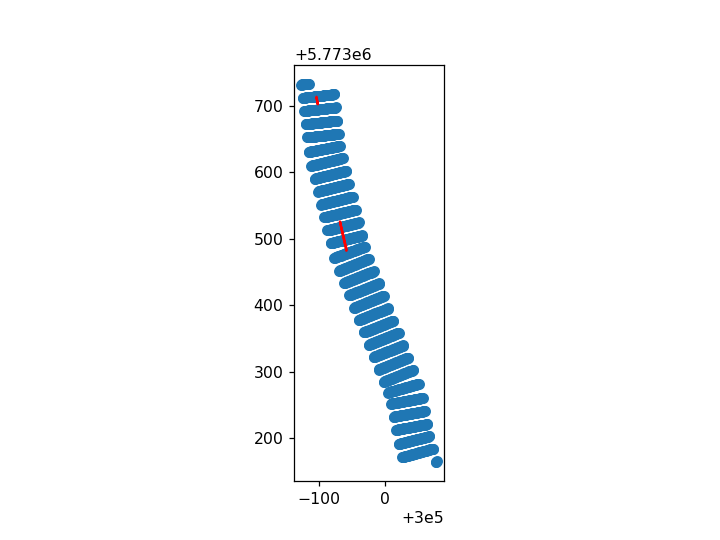

<AxesSubplot:>

In [161]:
f,ax=plt.subplots()
pts_gdf.plot(ax=ax)
intersection_gdf.boundary.plot(ax=ax, color='r')

In [29]:
{'init': 'epsg:32754'}

{'init': 'epsg:32754'}

In [27]:
crs=32754
crs_adhoc={'init': f'epsg:{crs}'}
crs_adhoc

{'init': 'epsg:32754'}

In [18]:
def check_overlaps_poly_label(label_corrections, profiles):
    for loc in label_corrections.location.unique():
        print(loc)
        for raw_date in label_corrections.query(f"location=='{loc}'").raw_date.unique():
            print(f"Check raw_date {raw_date}")
            for target_label_k in label_corrections.query(f"raw_date=={raw_date}").target_label_k.unique():
                print(f"Check target_label_k {target_label_k}")

                date_labelk_subset=label_corrections.query(f"raw_date=={raw_date} and target_label_k=={int(target_label_k)}")

                # if more than one polygons target the same label k, check if they overlap
                if len(date_labelk_subset)>1:
                    print(f"There are {len(date_labelk_subset)} corr polys")

                    # check if there are any one of them that overlaps       
                    for i,z in comb(range(len(date_labelk_subset)),2):
                        intersection_gdf = overlay(date_labelk_subset.iloc[[i]], date_labelk_subset.iloc[[z]], how='intersection')

                        if not intersection_gdf.empty:
                            
                           # check if the overlapping polygons have assigns different new_classes 
                            if any(intersection_gdf.new_class_1 != intersection_gdf.new_class_2):

                                # if overlap areas assign different classes, check if this area contains points.
                                # if contains points, raise an error as it does not make sense and the polygons must be corrected
                                # by the user

                                pts=profiles.query(f"location=='{loc}' and raw_date=={raw_date}")
                                pts['coordinates']=pts.coordinates.apply(coords_to_points)
                                pts_gdf=gpd.GeoDataFrame(pts, geometry='coordinates', crs=crs_dict_string[loc])

                                fully_contains = [intersection_gdf.geometry.contains(mask_geom)[0] for mask_geom in pts_gdf.geometry]

                                if True in fully_contains:
                                    idx_true=[i for i, x in enumerate(fully_contains) if x]
                                    raise ValueError(f"There are {len(intersection_gdf)} points in the overlap area of two label correction polygons (location: {loc}, raw_date: {raw_date}, target_label_k = {target_label_k}) which assign two different classes: {intersection_gdf.loc[:,'new_class_1'][0], intersection_gdf.loc[:,'new_class_2'][0]}. This doesn't make sense, please correct your label correction polygons. You can have overlapping polygons which act on the same target label k, but if they overlap points with such target_label_k, then they MUST assign the same new class.")

    print("Check terminated successfully")

In [19]:
check_overlaps_poly_label(label_corrections,profiles)

leo
Check raw_date 20180606
Check target_label_k 3
Check target_label_k 8
Check raw_date 20180713
Check target_label_k 5
Check target_label_k 6
Check raw_date 20180920
Check target_label_k 1
Check target_label_k 2
There are 2 corr polys
Check target_label_k 6
Check raw_date 20190211
Check target_label_k 2
Check target_label_k 6
There are 4 corr polys


C:\anaconda3\envs\sandpyper_env\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


Check target_label_k 7
Check raw_date 20190328
Check target_label_k 0
There are 2 corr polys
Check target_label_k 1
There are 2 corr polys
Check target_label_k 2
Check target_label_k 4
Check target_label_k 5
Check raw_date 20190731
Check target_label_k 1
Check target_label_k 3
Check target_label_k 7
Check target_label_k 6
There are 2 corr polys


C:\anaconda3\envs\sandpyper_env\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


ValueError: There are 1 points in the overlap area of two label correction polygons (location: leo, raw_date: 20190731, target_label_k = 6) which assign two different classes: ('sand', 'veg'). This doesn't make sense, please correct your label correction polygons. You can have overlapping polygons which act on the same target label k, but if they overlap points with such target_label_k, then they MUST assign the same new class.

<IPython.core.display.Javascript object>


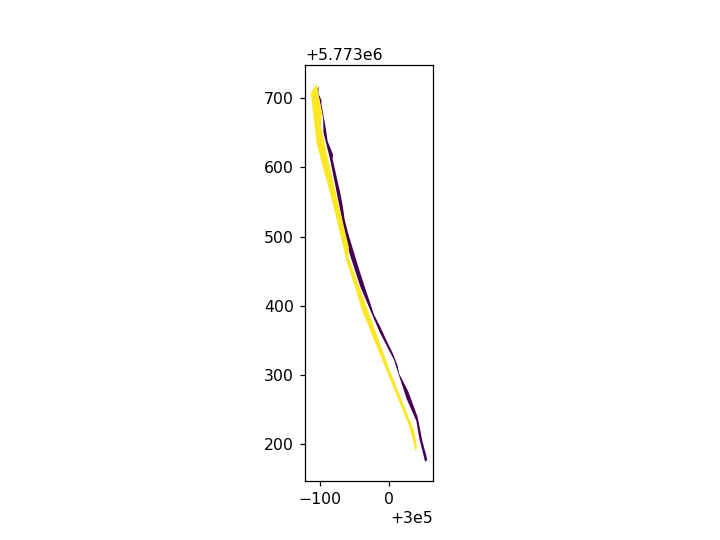

<AxesSubplot:>

In [67]:
f,ax=plt.subplots()

#to_clean_classified.query("point_id=='3300o21753081509le201'").plot(ax=ax)
#subset_finetune_polys[-2:].plot(column='index', alpha=.3, ax=ax)
intersection_gdf.reset_index().plot(ax=ax, column='index')

In [ ]:
to_update_finetune.query("point_id=='3300o21753081509le201'")

In [28]:
crs_dict_string


{'mar': {'init': 'epsg:32754'}, 'leo': {'init': 'epsg:32755'}}